In [1]:
import sys
import pickle
import pandas as pd
path: str = '/Users/juanbeta/My Drive/Research/Energy/E-CVRP-TW/Code/'
#path: str = 'C:/Users/jm.betancourt/Documents/Research/Energy//E-CVRP-TW/Code/'

from E_CVRP_TW import  E_CVRP_TW

sys.path.insert(0,path+'Experimentation/')
import plot_performance as plot

# Define instance to evaluate

In [2]:
env = E_CVRP_TW()

# Constructive

### Alpha configuration

Testing various alpha configurations

In [3]:
alphas = [0.15, 0.3, 0.5, 'Adaptative-Reactive']
data_alpha = {}
for instance in env.instances:
    data_alpha[instance] = {}
    for alpha in alphas:
        data_alpha[instance][alpha] = plot.retrieve_const_performance(instance, path+f'Experimentation/Constructive/alpha/{alpha}/')

In [4]:
print(' \t \t \t0.15 \t \t \t \t \t0.3 \t \t \t \t \t0.5 \t \t \t \t \tA-R')
print('Instance \tM \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts')

for instance in env.instances[:10]:
    env.load_data(instance)
    things = [instance, len(env.Costumers)]
    for alpha in alphas:
        things += [len(data_alpha[instance][alpha]['best individual']),
                    round(data_alpha[instance][alpha]['best distance'],2),
                    data_alpha[instance][alpha]['gap'],
                    round(data_alpha[instance][alpha]['time to find'],2),
                    ' ']
    print(*things,sep = '\t')

 	 	 	0.15 	 	 	 	 	0.3 	 	 	 	 	0.5 	 	 	 	 	A-R
Instance 	M 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s
c101C10.txt	10	4	446.26	13.33	0.05	 	4	446.26	13.33	0.02	 	4	446.26	13.33	0.09	 	4	446.26	13.33	0.02	 
c101C5.txt	5	3	250.04	-2.99	0.0	 	3	250.04	-2.99	0.0	 	3	250.04	-2.99	0.0	 	3	250.04	-2.99	0.0	 
c101_21.txt	100	20	1974.81	87.39	291.86	 	25	2177.8	106.66	147.62	 	24	2386.12	126.42	314.32	 	19	1978.33	87.73	285.96	 
c102_21.txt	100	21	1909.41	80.74	293.19	 	22	2164.92	104.92	351.44	 	22	2362.55	123.63	91.18	 	21	1933.55	83.02	193.59	 
c103C15.txt	15	4	437.79	13.92	2.58	 	5	426.56	11.0	37.59	 	3	409.81	6.64	26.22	 	5	426.56	11.0	24.92	 
c103C5.txt	5	2	165.67	-5.9	0.0	 	2	165.67	-5.9	0.0	 	2	165.67	-5.9	0.0	 	2	165.67	-5.9	0.02	 
c103_21.txt	100	18	1799.87	79.62	116.82	 	19	1951.41	94.75	125.52	 	20	2121.89	111.76	220.37	 	17	1719.19	71.57	449.53	 
c104C10.txt	10	2	281.8	2.87	0.28	 	2	281.8	2.87	0.36	 	2	279.93	2.19	6.96	 	2	279.93	2.19	2.07	 
c104_21.txt

In [8]:
instance = env.sizes['l'][20]
alpha = 0.5

print(f'########## Performance ##########')
print(f'incumbent: {round(data_alpha[instance][alpha]["best distance"],2)}')
print(f'gap: {round((data_alpha[instance][alpha]["best distance"] - env.bkFO[instance])/env.bkFO[instance]*100,2)}%')
print(f'time to find: {round(data_alpha[instance][alpha]["time to find"],2)}')

########## Performance ##########
incumbent: 2009.52
gap: 84.63%
time to find: 266.16


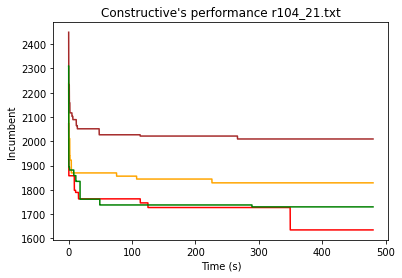

In [6]:
plot.plot_performance(data_alpha[instance],instance)
# 0.15 -> red
# 0.3 -> orange
# 0.5 -> browm
# Reactive-Adaptative -> green

### Restrictive criterion

Testing various restriction configuration for the RCL

In [ ]:
criterions = ['distance', 'TimeWindow','Intra-Hybrid', 'Exo-Hybrid']
data_crit = {}
for instance in env.instances:
    data_crit[instance] = {}
    for criterion in criterions:
        data_crit[instance][alpha] = plot.retrieve_const_performance(instance, path+f'Experimentation/Constructive/RCL criterion/{criterion}/')

In [ ]:
print(' \t \t \tDist \t \t \t \t \tTW \t \t \t \t \tHybrid')
print('Instance \tM \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts')

for instance in env.instances[:10]:
    env.load_data(instance)
    things = [instance, len(env.Costumers)]
    for criterion in criterions:
        things += [len(data_crit[instance][criterion]['best individual']),
                    round(data_crit[instance][criterion]['best distance'],2),
                    data_crit[instance][criterion]['gap'],
                    round(data_crit[instance][criterion]['time to find'],2),
                    ' ']
    print(*things,sep = '\t')

In [ ]:
instance = env.sizes['l'][20]
criterion = 'distance'

print(f'########## Performance ##########')
print(f'incumbent: {round(data_alpha[instance][criterion]["best distance"],2)}')
print(f'gap: {round((data_alpha[instance][criterion]["best distance"] - env.bkFO[instance])/env.bkFO[instance]*100,2)}%')
print(f'time to find: {round(data_alpha[instance][criterion]["time to find"],2)}')

# Operators

In [ ]:
##### Export data to Excel
d = {'instance': [], 'M':[]}
for instance in env.instances:
    env.load_data(instance)
    d['instance'].append(instance)
    d['M'].append(len(env.Costumers))

for alpha in alphas:
    d[f'{alpha}/# EV'] = [len(data[instance][alpha]['best individual']) for instance in env.instances]
    d[f'{alpha}/FO'] = [round(data[instance][alpha]['best distance'],2) for instance in env.instances]
    d[f'{alpha}/gap'] = [data[instance][alpha]['gap'] for instance in env.instances]
    d[f'{alpha}/t'] = [round(data[instance][alpha]['time to find'],2) for instance in env.instances]

df = pd.DataFrame(data = d)
df.to_excel('probando.xlsx')